# Love vs. Hate - An Analysis
## Hypothesis
Video titles with negative sentiment attract more viewers than video titles with positive sentiment.
## Methodology
### Dataset
Two playlists from youtube creator [gus1thego](https://www.youtube.com/@gus1thego) will be used to create the dataset:
1. [Country You LOVE? ❤️](https://www.youtube.com/playlist?list=PL__6zhSZ2VtUGsGaVYs7vKbP9CCaCuG6v)
2. [Country You HATE? 🤔](https://www.youtube.com/watch?v=iWqRAm-AmYc&list=PL__6zhSZ2VtW8H65tQHWRMqQeO0epayzB&pp=iAQB)

positive = False if Negative (2nd playlist)
positive = True if Positive (1st playlist)

In [2]:
import os

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

import json

import math
import re
from dataclasses import dataclass, field
from typing import List, Optional
import pandas as pd
import numpy as np

In [3]:
# Authorize Youtube API

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

# Disable OAuthlib's HTTPS verification when running locally.
# *DO NOT* leave this option enabled in production.
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "secrets.json"

# Get credentials and create an API client
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
    client_secrets_file, scopes)
credentials = flow.run_local_server(port=0)
youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=225811081325-p247u8vohb0uampck7gqhg5ufhb5t5h2.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A61425%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly&state=mkpyMooDIIIul3UrxGRj5A33KOjaGy&access_type=offline


In [4]:
playlist_ids = {
    "LOVE": "PL__6zhSZ2VtUGsGaVYs7vKbP9CCaCuG6v",
    "HATE": "PL__6zhSZ2VtW8H65tQHWRMqQeO0epayzB",
}



@dataclass
class Video:
    id: str
    title: str
    views: int
    likes: int
    favorites: int
    comments: int
    country: str = field(init=False)
    city: Optional[str] = field(init=False)
    positive: str = field(init=False)

    def __post_init__(self):
        print(self.title)
        location = re.sub(r'[\(\)]', '', self.title.split("|")[1]).strip().split(",")
        if len(location) == 1:
            self.city = None
            self.country = location[0].strip().title()
        elif len(location) == 2:
            self.city = location[0].strip().title()
            self.country = location[1].strip().title()
        
        self.positive = True if " love " in self.title.lower() else False

    def to_series(self) -> pd.Series:
        return pd.Series([self.id, self.title, self.views, self.likes, self.favorites, self.comments, self.country, self.city, self.positive])
    
    @staticmethod
    def get_column_labels() -> List[str]:
        return ["videoID", "title", "views", "likes", "favorites", "comments", "country", "city", "positive"]
    

def get_paginated(request_func, transformer=None, **kwargs):
    next_page_token = ""
    returns = []
    while True:
        request = request_func(**kwargs, pageToken=next_page_token if next_page_token != "" else None)
        response = request.execute()
        returns += transformer(response) if transformer else response
        if "nextPageToken" not in response:
            break
        next_page_token = response["nextPageToken"]
    return returns
def get_video_list_from_playlist(playlist_id) -> List[Video]:
    video_ids = get_paginated(
        youtube.playlistItems().list,
        transformer = lambda response: list(map(lambda entry: entry["contentDetails"]["videoId"], response["items"])),
        part="contentDetails", playlistId=playlist_id, maxResults=50
    )
    videos = []
    while len(video_ids) > 0:
        section = 50 if len(video_ids) >= 50 else len(video_ids)
        request = youtube.videos().list(part="statistics,snippet", id=",".join(video_ids[:section]))
        response = request.execute()
        videos += [
            Video(
                entry["id"],
                entry["snippet"]["title"],
                int(entry["statistics"]["viewCount"]),
                int(entry["statistics"]["likeCount"]),
                int(entry["statistics"]["favoriteCount"]),
                int(entry["statistics"]["commentCount"]),
            )
            for entry in filter(lambda entry: "which country do you" in entry["snippet"]["title"].lower(), response["items"])
        ]
        del video_ids[:section]
    return videos

love_videos = get_video_list_from_playlist(playlist_ids["LOVE"])
hate_videos = get_video_list_from_playlist(playlist_ids["HATE"])

Which Country Do You LOVE The Most? | COPENHAGEN, DENMARK
Which Country Do You LOVE The Most? | (HAMBURG, GERMANY)
Which Country Do You LOVE The Most? | SWEDEN, YSTAD
Which Country Do You LOVE The Most? | FAROE ISLANDS
Which Country Do You LOVE The Most? | DUBLIN, IRELAND
Which Country Do You LOVE The Most? | ROME, ITALY
Which Country Do You LOVE The Most? | AUSTRIA
Which Country Do You LOVE The Most? | SCOTLAND
Which Country Do You LOVE The Most? | FRANCE
Which Country Do You LOVE The Most? | PORTUGAL
Which Country Do You LOVE The Most? | ISTANBUL, TURKEY
Which Country Do You LOVE The Most? | ENGLAND
Which Country Do You LOVE The Most? | POLAND
Which Country Do You LOVE The Most? | CZECH REPUBLIC
Which Country Do You LOVE The Most? | UKRAINE
Which Country Do You LOVE The Most? | SERBIA
Which Country Do You LOVE The Most? | ESTONIA
Which Country Do You LOVE The Most? | CROATIA
Which Country Do You LOVE The Most? | LIBYA
Which Country Do You LOVE The Most? | FINLAND
Which Country Do You

In [5]:
def videos_to_dataframe(videos: List[Video]):
    df = pd.DataFrame([video.to_series() for video in videos])
    df.columns = Video.get_column_labels()
    return df

df = videos_to_dataframe(love_videos + hate_videos)

Now we have a dataframe to clean-up:
1. Some of the cities and countries may be swapped due to inconsistencies in the video titles.
2. Probably don't need video titles, as all the necessary information has been extracted, so we'll drop it. We'll also drop videoID's.

In [6]:
df[df["city"].notna()] # Check all rows w/ city and country entries to check if any were stored incorrectly

,videoID,title,views,likes,favorites,comments,country,city,positive
0,dREo5nYiH0k,Which Country Do You LOVE The Most? | COPENHAG...,54593,828,0,178,Denmark,Copenhagen,True
1,MlVALq8FOXc,Which Country Do You LOVE The Most? | (HAMBURG...,116657,1909,0,879,Germany,Hamburg,True
2,3iqFlG3o7G8,"Which Country Do You LOVE The Most? | SWEDEN, ...",154879,2020,0,695,Ystad,Sweden,True
4,mtKorzbpm4c,"Which Country Do You LOVE The Most? | DUBLIN, ...",163746,2053,0,932,Ireland,Dublin,True
5,s92ex187-ys,"Which Country Do You LOVE The Most? | ROME, ITALY",152925,2498,0,1275,Italy,Rome,True
10,HoGJBkzfjMs,Which Country Do You LOVE The Most? | ISTANBUL...,227903,4018,0,2513,Turkey,Istanbul,True
31,iuB-iCAytx0,"Which Country Do You LOVE The Most? | Munich, ...",219520,4485,0,1857,Germany,Munich,True
34,s5CGMmrfg9o,"Which Country Do You LOVE The Most? | KADIKOY,...",306128,7374,0,5065,Turkey,Kadikoy,True
97,UlPwLeWhVDs,"Which Country Do You HATE The Most? | HAMBURG,...",1829507,34837,0,7903,Germany,Hamburg,False
100,hrunWjHz2PE,"Which Country Do You HATE The Most? | DUBLIN, ...",2876047,36161,0,14595,Ireland,Dublin,False


In [7]:
# We see that one entry (3iqFlG3o7G8) has the country as Ystad and the city as Sweden. Let's fix that:
df.at[2, "country"] = "Sweden"
df.at[2, "city"] = "Ystad"
df

,videoID,title,views,likes,favorites,comments,country,city,positive
0,dREo5nYiH0k,Which Country Do You LOVE The Most? | COPENHAG...,54593,828,0,178,Denmark,Copenhagen,True
1,MlVALq8FOXc,Which Country Do You LOVE The Most? | (HAMBURG...,116657,1909,0,879,Germany,Hamburg,True
2,3iqFlG3o7G8,"Which Country Do You LOVE The Most? | SWEDEN, ...",154879,2020,0,695,Sweden,Ystad,True
3,Ff01kfHDX18,Which Country Do You LOVE The Most? | FAROE IS...,52404,885,0,177,Faroe Islands,None,True
4,mtKorzbpm4c,"Which Country Do You LOVE The Most? | DUBLIN, ...",163746,2053,0,932,Ireland,Dublin,True
...,...,...,...,...,...,...,...,...,...
186,Q-f2abgg4NE,Which Country Do You HATE The Most? | PAPUA NE...,27932,427,0,506,Papua New Guinea,None,False
187,4Z_Sw1oWygc,Which Country Do You HATE The Most? | PHILIPPINES,23560,526,0,979,Philippines,None,False
188,1gzpzCPlqGQ,Which Country Do You HATE The Most? | MALAYSIA,38269,591,0,846,Malaysia,None,False
189,Nk19ahJe8zI,Which Country Do You HATE The Most? | THAILAND,10718,229,0,312,Thailand,None,False


Our basic data cleaning is done! Let's save to file and then do some more modifications for our visualizations...

In [8]:
# Write to file
df.to_csv("./data/data.csv")

In [9]:
# Let's drop the video titles and videoIDs now
if "videoID" in df.columns:
    df.drop("videoID", axis=1, inplace=True)
if "title" in df.columns:
    df.drop("title", axis=1, inplace=True)

In [10]:
# Convert positive column to binary integers (0,1)
df["positive"] = df["positive"].astype(int)
df

,views,likes,favorites,comments,country,city,positive
0,54593,828,0,178,Denmark,Copenhagen,1
1,116657,1909,0,879,Germany,Hamburg,1
2,154879,2020,0,695,Sweden,Ystad,1
3,52404,885,0,177,Faroe Islands,None,1
4,163746,2053,0,932,Ireland,Dublin,1
...,...,...,...,...,...,...,...
186,27932,427,0,506,Papua New Guinea,None,0
187,23560,526,0,979,Philippines,None,0
188,38269,591,0,846,Malaysia,None,0
189,10718,229,0,312,Thailand,None,0


In [11]:
# Let's remove some outliers with Z-score
def remove_outliers(df: pd.DataFrame, threshold: int = 3):
    removal_thresh = threshold
    mean = df["views"].mean()
    stdev = df["views"].std()
    print(mean, stdev)
    _zscores = df["views"].apply(lambda count: abs((count-mean)/stdev))
    df.drop(index=_zscores[_zscores > removal_thresh].index, inplace=True)

remove_outliers(df, 2)

331835.9267015707 563539.6537612807


<Axes.ArtistList of 2 patches>


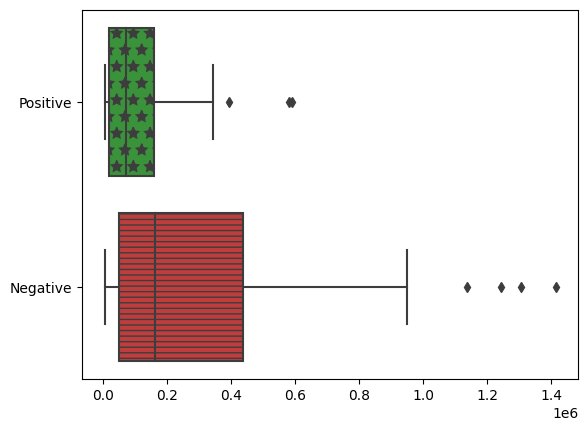

In [12]:
# Let's plot!
import seaborn as sns
import matplotlib.pyplot as plt
neg_views, pos_views = df[df["positive"] == 0][["views"]], df[df["positive"] == 1][["views"]]
neg_views.reset_index(inplace=True, drop=True)
pos_views.reset_index(inplace=True, drop = True)
neg_views.rename({"views": "neg views"}, axis=1, inplace=True)
pos_views.rename({"views": "pos views"}, axis=1, inplace=True)
plt.ticklabel_format(style='plain', axis='x')
plt.xscale("linear")
ax = sns.boxplot(data=[pos_views, neg_views], orient="h", palette={0: "tab:green", 1: "tab:red"})
ax.set_yticklabels(["Positive", "Negative"])

# styling just for fun
hatches = ["*","---"]
print(ax.patches)
for i in range(len(hatches)):
    ax.patches[i].set_hatch(hatches[i])

plt.show()

1100.2 3860.7


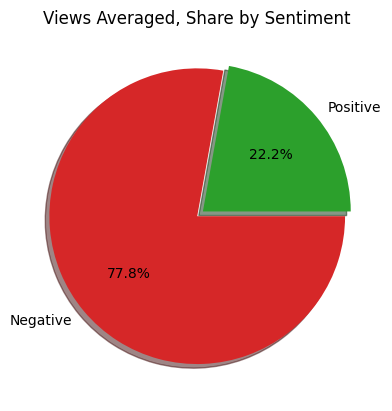

In [13]:
fig, ax = plt.subplots()
pvpv = (pos_views.mean()/pos_views.count()).round(1).values[0] # 1100.18207
nvpv = (neg_views.mean()/neg_views.count()).round(1).values[0] # 3428.86933
print(pvpv, nvpv)
ax.pie([pvpv, nvpv], explode=(0.05, 0), labels=["Positive", "Negative"], autopct='%1.1f%%', colors=['tab:green','tab:red'], shadow=True)
ax.set_title("Views Averaged, Share by Sentiment")
plt.show()

# Conclusion
From the visualizations above, our hypothesis has been proven. The HATE videos received far more views on average than the LOVE videos, even with significant outliers removed.

Thus, in this case, video titles with negative sentiment attract more viewers than video titles with positive sentiment.